In [1]:
import pandas as pd
import numpy as np
from scipy import stats, interpolate
import matplotlib.pyplot as plt
import os
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
from ipywidgets import interact

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, DotProduct, Product, WhiteKernel, Sum

# get a list of all the colour strings in matplotlib so we can iterate through them
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
colour_list = list(colors.keys())
# 9 base colours ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w', 'aliceblue', 'antiquewhite', 'aqua'...

# Behind The Scenes Code

Read in Iteration Data (Training and NNet). Does all of the ugly calculations. Note, when the actions are changed, only self.action_space needs to be changed.

In [2]:
class IterationData:
    """
    A class to load in the data from each iteration to an object in a readable form for later visualisation
    Note:
        GOOD get_state_2d(episode, step)
        BAD state_2ds[\'arr_x\']
    """

    def __init__(self, folder_path, iteration):

        self.training_path = folder_path + 'TrainingExamples' + str(iteration)
        self.nnet_loss_path = folder_path + 'NNetLosses' + str(iteration)

        # data formatting
        self.decimal_places = 3
        self.csv_rows = 6
        self.action_space = [-1, 1]

        # data manipulation
        self.x_threshold = 2.4
        self.theta_threshold_radians = 0.21

        # define a useful class for training examples, so we can access dict memebers as .'key' rather than ['key']
        class ReturnClass(dict):
            def __getattr__(self, name):
                return self[name]

        # just get the number of episodes (need to do this before adding episodes to the dict annoyingly)
        with open(self.training_path + '.csv', 'r', newline='') as f:
            row_count = sum([1 for row in f])
        self.episodes = int(row_count / self.csv_rows)

        # read in training examples data and nnet loss data
        # dict of {ep1: dataframe[2Dstate, TrueValue, PolicyValue, MCTSAction, PolicyAction, Observation], ep2: ...}
        self.episode_data = ReturnClass()
        self.all_data = pd.DataFrame(
            columns=['TrueValue', 'PolicyValue', 'MCTSAction', 'PolicyAction', 'Player', 'Observation',
                     'State2D'])
        self.state_2ds = np.load(self.training_path + '.npz')
        self.read_examples()
        self.nnet_losses = self.read_nnet_losses()

    def read_examples(self):
        step_counter = 0
        for episode in range(self.episodes):
            rows = [self.csv_rows * episode + x for x in range(self.csv_rows)]

            # only pick out relevent rows (because others are different lengths -> can't be read)
            episode_data = pd.read_csv(self.training_path + '.csv', header=None,
                                       skiprows=lambda x: x not in rows).transpose()
            episode_data.columns = ['TrueValue', 'PolicyValue', 'MCTSAction', 'PolicyAction', 'Player',
                                    'Observation']
            episode_data.TrueValue = episode_data.TrueValue.astype(float).round(self.decimal_places)
            episode_data.PolicyValue = episode_data.PolicyValue.astype(float).round(self.decimal_places)
            episode_data.Player = episode_data.Player.astype(int)

            # Split arrays and convert to floats
            episode_data.MCTSAction = episode_data.MCTSAction.apply(lambda x: x[1:-1].split(', '))
            episode_data.MCTSAction = episode_data.MCTSAction.apply(
                lambda x: [round(float(elm), self.decimal_places) for elm in x])

            episode_data.PolicyAction = episode_data.PolicyAction.apply(lambda x: x[1:-1].split(', '))
            episode_data.PolicyAction = episode_data.PolicyAction.apply(
                lambda x: [round(float(elm), self.decimal_places) for elm in x])

            episode_data.Observation = episode_data.Observation.apply(lambda x: x[1:-1].split())
            episode_data.Observation = episode_data.Observation.apply(
                lambda x: [round(float(elm), self.decimal_places) for elm in x])

            # add a reference to the stated2D for each step
            episode_states = list(self.state_2ds)[step_counter:step_counter + episode_data.index[-1] + 1]
            step_counter += episode_data.index[-1] + 1
            episode_data['State2D'] = episode_states

            # and then add the whole dataframe to the dict
            self.episode_data['Episode' + str(episode)] = episode_data
            self.all_data = pd.concat([self.all_data, episode_data], ignore_index=True)

    def read_nnet_losses(self):
        losses = pd.read_csv(self.nnet_loss_path + '.csv', names=['PlayerAction', 'PlayerValue', 'AdversaryAction', 'AdversaryValue'])
        return losses

    def get_state_2d(self, episode, step):
        episode = 'Episode' + str(episode)
        return self.state_2ds[self.episode_data[episode].State2D.values[step]]

    def get_episode_length(self, episode):
        episode = 'Episode' + str(episode)
        return self.episode_data[episode].index[-1]

    def get_max_episode(self):
        max_ep_len, max_ep = 0, 0
        for ep in range(self.episodes):
            ep_len = self.get_episode_length(ep)
            if ep_len > max_ep_len:
                max_ep_len = ep_len
                max_ep = ep
        return max_ep

folder = os.path.join('..\Cartpole','Data', 'TrainingData\\')
iter_data = IterationData(folder, iteration=0)
iter_data.episode_data['Episode0'].tail()
iter_data.all_data.tail()

,TrueValue,PolicyValue,MCTSAction,PolicyAction,Player,Observation,State2D
1399,-0.419,-0.492,"[0.846, 0.154]","[0.478, 0.522]",1,"[-0.47, -0.517, 0.091, 1.197]",arr_1399
1400,-0.568,-0.520,"[0.397, 0.603]","[0.441, 0.559]",0,"[-0.481, -0.519, 0.115, 1.236]",arr_1400
1401,-0.674,-0.490,"[0.5, 0.5]","[0.468, 0.532]",1,"[-0.491, -0.72, 0.14, 1.682]",arr_1401
1402,-0.778,-0.525,"[0.426, 0.574]","[0.423, 0.577]",0,"[-0.505, -0.723, 0.174, 1.742]",arr_1402
1403,-0.977,-0.493,"[0.481, 0.519]","[0.473, 0.527]",1,"[-0.52, -0.526, 0.209, 1.422]",arr_1403


Class To Visualise a Single Iteration. Generally these don't go quite as far as plotting, they create and return an axes object, which can then be plotted, or used in the Visualise class, which compares iterations

In [3]:
from VisualiseIteration import VisualiseIteration

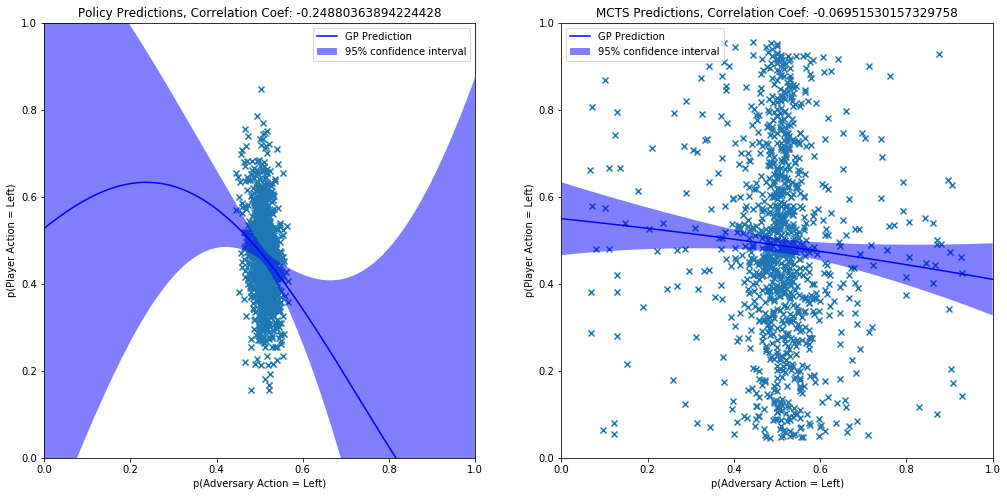

In [4]:
vis = VisualiseIteration(folder, 1)
vis.plot_action_correlations()

In [5]:
from VisualiseIterations import VisualiseIterations
help(VisualiseIterations)

Help on class VisualiseIterations in module VisualiseIterations:

class VisualiseIterations(builtins.object)
 |  VisualiseIterations principally contains a list of VisualiseIteration objects, which in turn contain Iteration data objects
 |  leading to an objects hirachy of VisualiseIterations <- Iter*VisualiseIteration <- IterationData. The main components of
 |  the two attribute classes are shown below:
 |  
 |  VisualiseIterations:
 |  Attributes:
 |      self.iters_data = [iter_data0, iter_data1, iter_data2, ...]
 |      self.iterations
 |  
 |  VisualiseIteration:
 |  Attributes:
 |      self.iter, self.action_space = [-1, 1], self.action_names ={0: 'Left', 1: 'Right'}
 |      self.default_action = 0  # left is default action to show (no need to show left and right)
 |      iter_data = IterationData(folder_path, iteration)
 |  Methods:
 |      add_axis_valuevsstep(self, episode=None, colour = 'blue', axes=None)
 |      add_axis_actionvsstep(self, episode=None, agent='player', colo

In [10]:
class VisualiseIterations:
    """
    VisualiseIterations principally contains a list of VisualiseIteration objects, which in turn contain Iteration data objects
    leading to an objects hirachy of VisualiseIterations <- Iter*VisualiseIteration <- IterationData. The main components of
    the two attribute classes are shown below:

    VisualiseIterations:
    Attributes:
        self.iters_data = [iter_data0, iter_data1, iter_data2, ...]
        self.iterations

    VisualiseIteration:
    Attributes:
        self.iter, self.action_space = [-1, 1], self.action_names ={0: 'Left', 1: 'Right'}
        self.default_action = 0  # left is default action to show (no need to show left and right)
        iter_data = IterationData(folder_path, iteration)
    Methods:
        add_axis_valuevsstep(self, episode=None, colour = 'blue', axes=None)
        add_axis_actionvsstep(self, episode=None, agent='player', colour = 'blue', axes=None)
        get_episode_value_stats(self)
        plot_observations_histogram(self, normalised=True)
        get_actionvsstate_probs(self, policy, x_dot_fixed=0, theta_dot_fixed=0, bin_proportion=0.15)
        add_axis_actionprobvsstate(self, prob_array, axes, agent='player', vs=(0.2, 0.8))
        plot_state_2d(self, episode, step)

    IterationData:
    Attributes:
        self.episodes = number of episodes in an iteration
        self.nnet_losses = Dataframe with ['PlayerAction', 'AdversaryAction', 'Value', 'Total'] as the column headders
        self.episode_data = A Dictionary of episodes with keys ['EpisodeN'] where N is an int.
                Each episode's value is a pandas dataframe with columns:

    ['TrueValue', 'PolicyValue', 'MCTSAction', 'PolicyAction', 'MCTSAdv', 'PolicyAdv',  'Observation',      'State2D']
      [ float,      float,         [f, f],        [f, f],      [f, f],     [f, f],  [x, xdot, theta, thetadot], 'arr_n']

        self.all_data = all of the episode data joined in columns as above

    Methods:
        get_state_2d(self, episode, step)
        get_episode_length(self, episode)
        get_max_episode(self)
    """

    def __init__(self, data_set_path, iters='all'):
        self.folder_path = data_set_path

        self.iters_data = []
        if iters == 'all':
            self.iterations = 0
            while True:
                try:
                    self.iters_data.append(VisualiseIteration(self.folder_path, self.iterations))
                except:
                    break
                self.iterations += 1
        else:
            assert isinstance(iters, list)
            for itr in iters:
                self.iters_data.append(VisualiseIteration(self.folder_path, itr))
            self.iterations = len(self.iters_data)

        print("There are ", self.iterations, " iterations stored in self.iterations")

    def plot_episode_statsvsstep(self, iters=(0, 1, 2), plot_stds=False, plot_all_eps=False):
        assert all(i < self.iterations for i in iters), "Some iterations are not valid!"

        fig = plt.figure(figsize=(17, 7))
        axes = fig.add_axes([0, 0, 1, 1])
        axes.set_xlabel('Steps')
        axes.set_ylabel('Average Value')
        axes.set_ylim([-1, 0])
        for itr in iters:
            means, std, all_eps = self.iters_data[itr].get_episode_value_stats()

            axes.plot(means, linestyle='-', color=colour_list[itr], label='Itr:' + str(itr) + ' Average Episode Value')
            if plot_stds:
                axes.plot(means + std, linestyle='--', color=colour_list[itr], label=None)
                axes.plot(means - std, linestyle='--', color=colour_list[itr], label=None)
            if plot_all_eps:
                for i in range(self.iters_data[itr].iter_data.episodes):
                    axes.plot(all_eps[i], linestyle=':', label=None)

            axes.legend()

    def plot_nnet_lossesvsbatch(self, iters=(0, 1, 2)):
        assert all(i < self.iterations for i in iters), "Some iterations are not valid!"

        fig = plt.figure(figsize=(17, 7))
        axes = fig.add_axes([0, 0, 1, 1])

        axes.set_xlabel('Batches (size 8)')
        axes.set_ylabel('Loss')
        for itr in iters:
            axes.plot(self.iters_data[itr].iter_data.nnet_losses.values)
            axes.legend(['Itr ' + str(itr) + ' Player Action', 'Itr ' + str(itr) + ' Adversary Action',
                         'Itr ' + str(itr) + ' Value', 'Itr ' + str(itr) + ' Total'])

    def plot_observation_histograms(self, iters=(0, 1, 2), normed=True):
        for itr in iters:
            self.iters_data[itr].plot_observations_histogram(normed)

    def plot_valuesvssteps(self, iters=(0, 1, 2), episodes='longest'):
        # fig, ax = te0.plot_episode(episode=3, colour='blue')
        max_eps = []
        for itr in iters:
            if episodes == 'longest':
                max_eps.append(self.iters_data[itr].iter_data.get_max_episode())
            if isinstance(episodes, list):
                pass

        # keep plotting iterations on the same axis
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(17, 7))
        for idx, itr in enumerate(iters):
            ax = self.iters_data[itr].add_axis_valuevsstep(max_eps[idx], colour_list[idx], ax)

    def plot_actionsvssteps(self, iters=(0, 1, 2), episodes='longest'):
        max_eps = []
        for itr in iters:
            if episodes == 'longest':
                max_eps.append(self.iters_data[itr].iter_data.get_max_episode())
                pass
            if isinstance(episodes, list):
                pass
        # plot those episodes, one for the player and one for the adversary
        fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(17, 2 * 7))
        for idx, itr in enumerate(iters):
            ax = self.iters_data[itr].add_axis_actionvsstep(max_eps[idx], colour_list[idx], ax)

    def plot_playervsadversary(self, iters=(0, 1, 2,)):
        for itr in iters:
            self.iters_data[itr].plot_action_correlations()

    def plot_actionprobsvsstates(self, iters=(0, 1, 2), policy=True, x_dot_fixed=0, theta_dot_fixed=0, bin_prop=0.05,
                                 colourbar_lims=(0, 1)):
        assert all(i < self.iterations for i in iters), "Some iterations are not valid!"

        for itr in iters:
            player_probs, adversary_probs = self.iters_data[itr].get_actionvsstate_probs(policy, x_dot_fixed,
                                                                                         theta_dot_fixed, bin_prop)

            # Plot the things
            fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(17, 5), sharey=True)
            ax, im = self.iters_data[itr].add_axis_actionprobvsstate(player_probs, axes[0], agent='player',
                                                                     vs=colourbar_lims)
            ax, im = self.iters_data[itr].add_axis_actionprobvsstate(adversary_probs, axes[1], agent='adversary',
                                                                     vs=colourbar_lims)

            fig.subplots_adjust(right=0.8)
            cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
            fig.colorbar(im, cax=cbar_ax)

    def vs_state_3d(self, angle=45, iteration=0, data_set='PolicyAction', omitted_state='x_dot', omitted_state_value=0,
                    binsize=0.15):

        cmap = 'viridis' if data_set in ['PolicyAction', 'PolicyAdv', 'PolicyValue'] else 'plasma'
        colour_ttl = 'State Value' if data_set in ['PolicyValue',
                                                   'TrueValue'] else 'Probability of \n the Agent Pushing Left'
        non_omitted_state_idx = 1 if omitted_state == 'theta_dot' else 3
        itr = iteration

        try:
            # print(self.iters_data[itr], self.iters_data[itr].iter_data)
            action_or_value = list(zip(*self.iters_data[itr].iter_data.all_data[data_set].values))[0]
        except:
            action_or_value = self.iters_data[itr].iter_data.all_data[data_set].values
        obs = list(zip(*self.iters_data[itr].iter_data.all_data['Observation'].values))

        # set up the plot
        fig = plt.figure(figsize=(17, 14))
        ax = fig.add_subplot(111, projection='3d')
        if omitted_state == 'theta_dot':
            omitted_obs = np.array(obs[3])
            ax.set_ylabel('$\dot{x}$, x-velocity (m/s)')
            ax.set_title(
                'Iteration {} {} with $\dot{{\\theta}}$ = {}$\pm${} rad/s'.format(itr, data_set, omitted_state_value,
                                                                                  binsize))

        else:
            omitted_obs = np.array(obs[1])
            ax.set_ylabel('$\dot{\\theta}$, angular velocity (rad/s)')
            ax.set_title(
                'Iteration {} {} with $\dot{{x}}$ = {}$\pm${} m/s'.format(itr, data_set, omitted_state_value, binsize))

        x_min, x_max = min((obs[0])) - 1, max(obs[0])
        omitted_min, omitted_max = min(omitted_obs) - 1, max(omitted_obs)
        theta_min, theta_max = min(obs[2]) - 0.25, max(obs[2])

        # extract the relavent points
        is_near_filter = (omitted_obs > omitted_state_value - binsize) & (omitted_obs < omitted_state_value + binsize)
        x, y, z = np.array(obs[0])[is_near_filter], np.array(obs[non_omitted_state_idx])[is_near_filter], \
                  np.array(obs[2])[is_near_filter]
        density = np.array(action_or_value)[is_near_filter]

        # plot the main plot
        ax.scatter(x, y, z, c=density, alpha=1, cmap=cmap)
        ax.set_xlabel('x position (m)')
        ax.set_zlabel('$\\theta$ position (rad)')

        # and add the 2d compressed versions

        ax.scatter(x, y, theta_min, zdir='z', c=density, s=5, alpha=0.5, cmap=cmap)
        ax.scatter(x_min, y, z, zdir='z', c=density, s=5, alpha=0.5, cmap=cmap)
        ax.scatter(x, omitted_min, z, zdir='z', c=density, s=5, alpha=0.5, cmap=cmap)

        ax.set_xlim(x_min, x_max)
        ax.set_ylim(omitted_min, omitted_max)
        ax.set_zlim(theta_min, theta_max)

        # sort out the colourbar
        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
        mappable = cm.ScalarMappable(cmap=cmap)
        mappable.set_array(density)
        mappable.set_clim(min(action_or_value), max(action_or_value))
        plt.colorbar(mappable, cax=cbar_ax)
        cbar_ax.set_title(colour_ttl)

        ax.view_init(25, angle)
        plt.show()

In [11]:
folder = os.path.join('..\Cartpole', 'Data', 'TrainingData\\')
v = VisualiseIterations(folder, [0, 1, 2])

There are  3  iterations stored in self.iterations


In [30]:
interact(v.vs_state_3d, angle=(0, 180, 5),
         iteration=(0 , v.iterations-1, 1),
         data_set=['PolicyAction', 'MCTSAction', 'PolicyAdv', 'MCTSAdv', 'PolicyValue', 'TrueValue'], 
         omitted_state=['x_dot', 'theta_dot'], 
         omitted_state_value=(-3, 3, 0.1), 
         binsize=(0.05, 2, 0.05))

interactive(children=(IntSlider(value=45, description='angle', max=180, step=5), IntSlider(value=0, descriptio…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

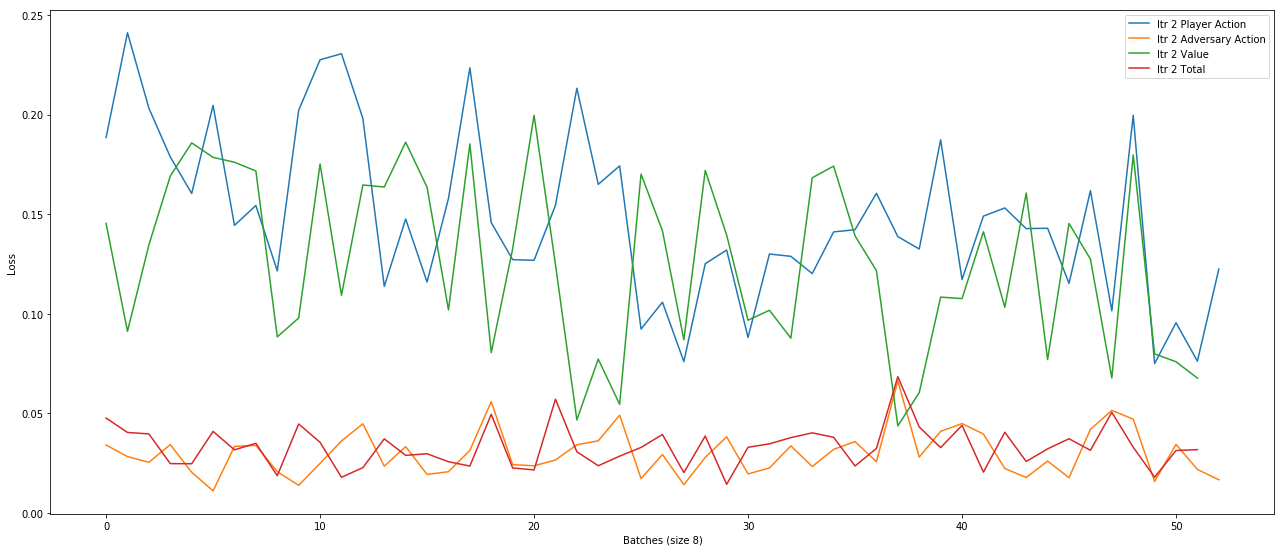

In [12]:
v.plot_nnet_lossesvsbatch(iters=[2])

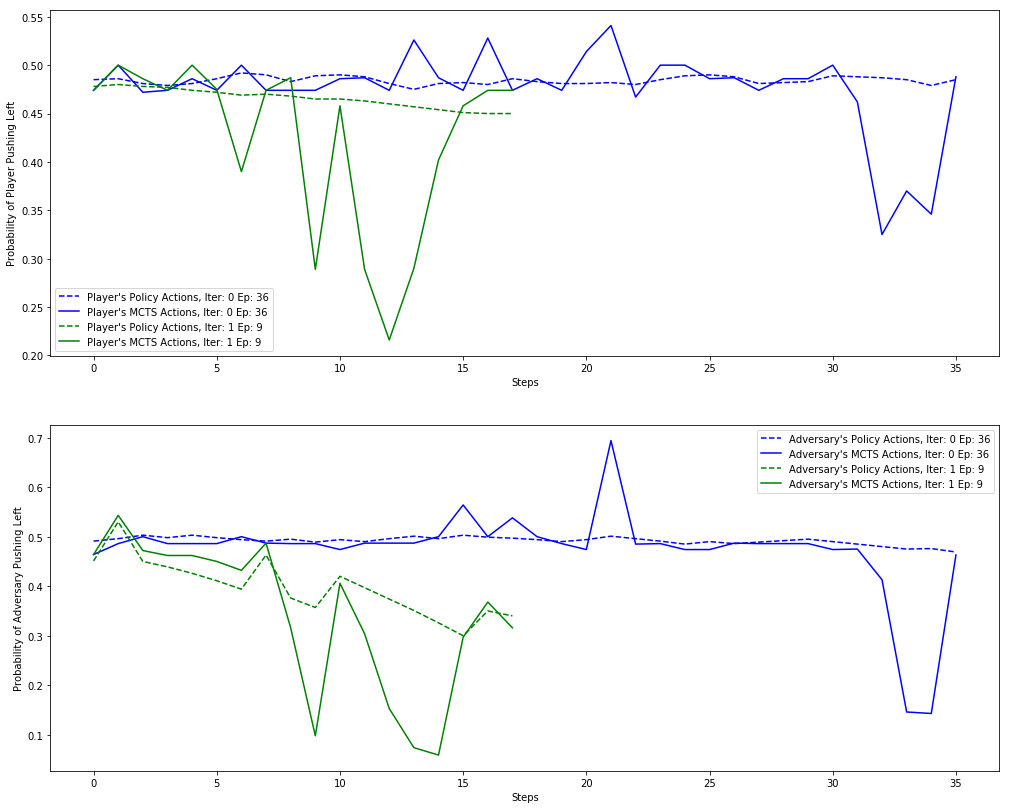

In [9]:
v.plot_actionsvssteps(iters=(0, 1), episodes='longest')

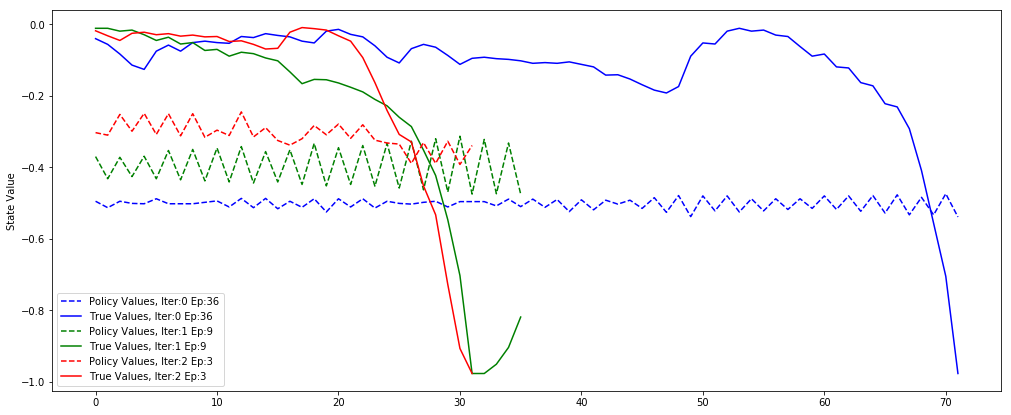

In [10]:
v.plot_valuesvssteps(iters=(0, 1, 2), episodes='longest')

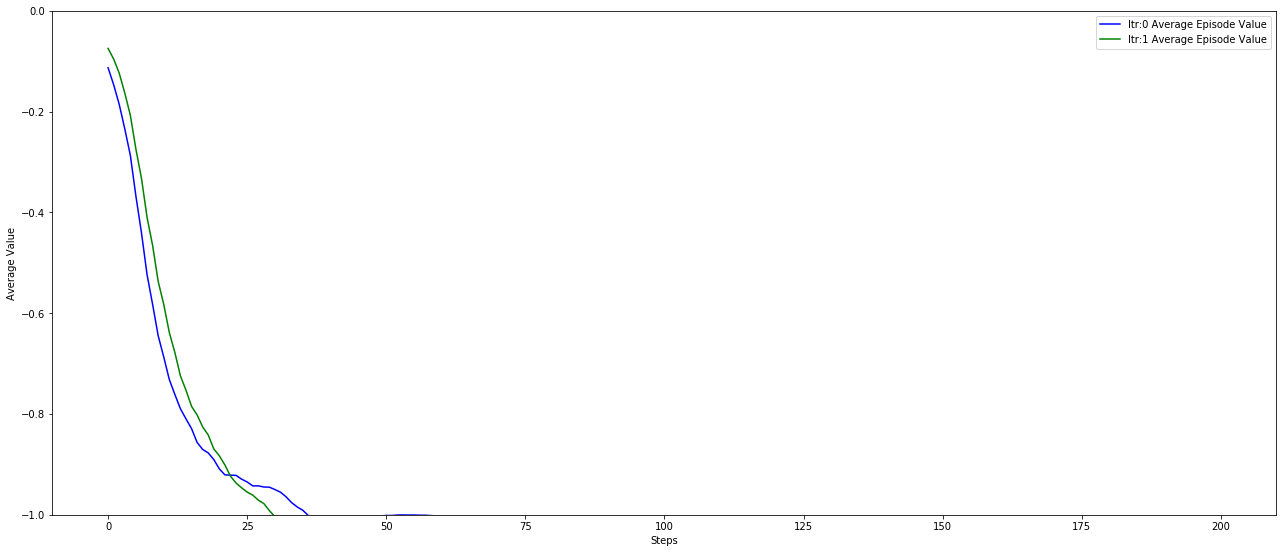

In [11]:
v.plot_episode_statsvsstep(iters=[0, 1])

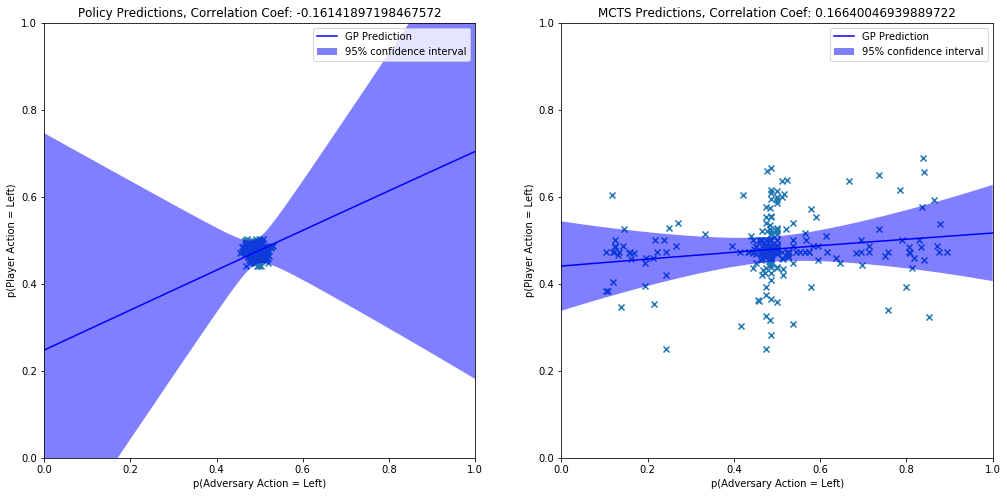

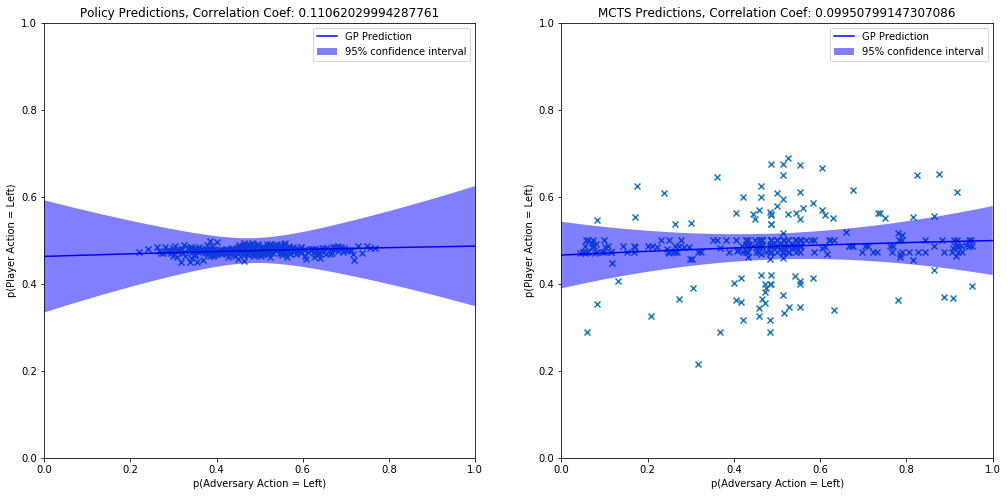

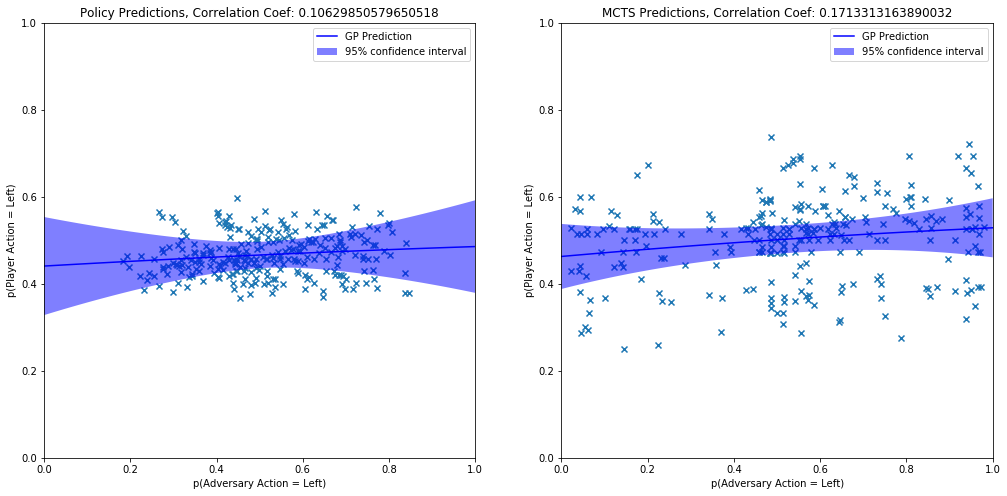

In [12]:
v.plot_playervsadversary(iters=(0, 1, 2))

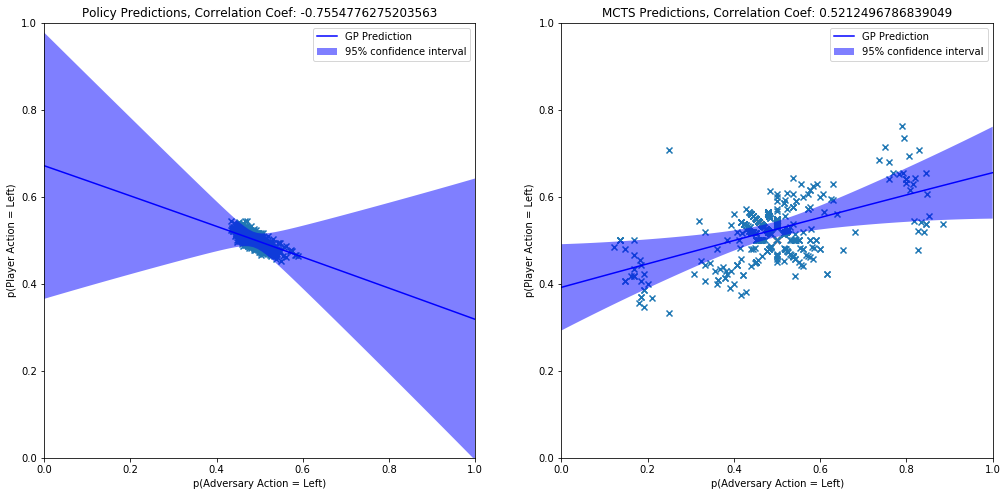

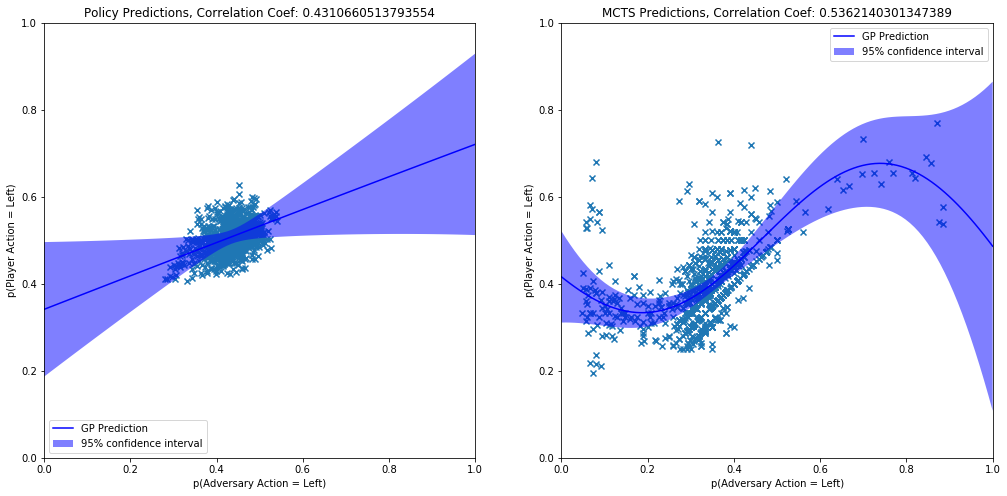

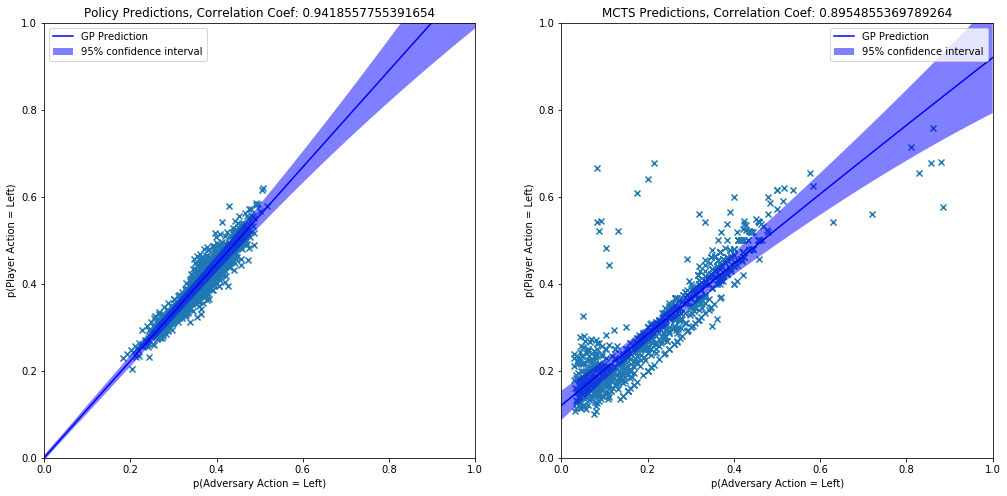

In [46]:
v.plot_playervsadversary(iters=(0, 1, 2))

C:\Users\Alex\Documents\Cambridge\IIB\Project\ResultsAndTesting\VisualiseIteration.py:190: RuntimeWarning: invalid value encountered in true_divide
  player_probs = np.true_divide(player_probs, player_counter)
C:\Users\Alex\Documents\Cambridge\IIB\Project\ResultsAndTesting\VisualiseIteration.py:191: RuntimeWarning: invalid value encountered in true_divide
  adv_probs = np.true_divide(adv_probs, adv_counter)


TypeError: Invalid dimensions for image data

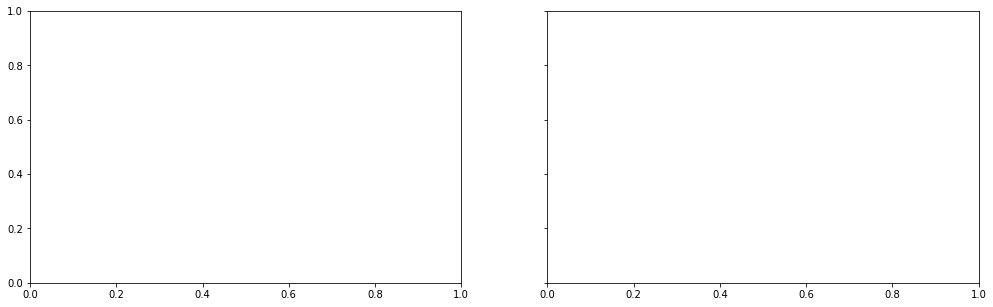

In [56]:
v.plot_actionprobsvsstates(iters=(0, 1, 2), policy=True, x_dot_fixed=0, theta_dot_fixed=0, bin_prop=0.05, colourbar_lims=(0, 1))

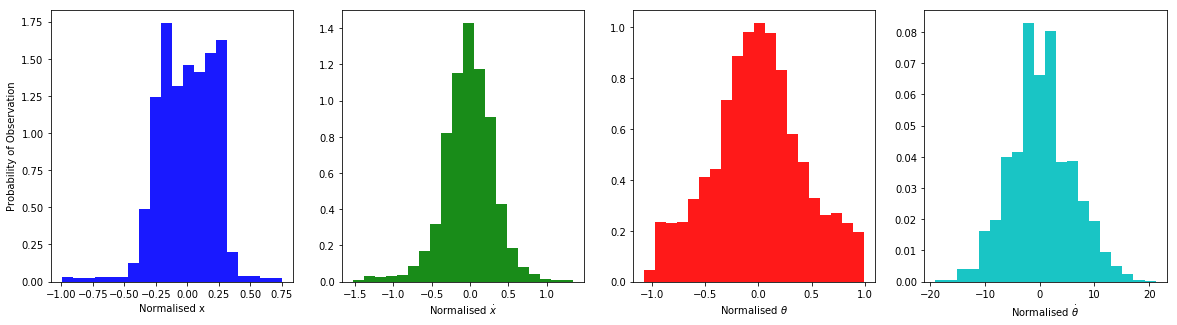

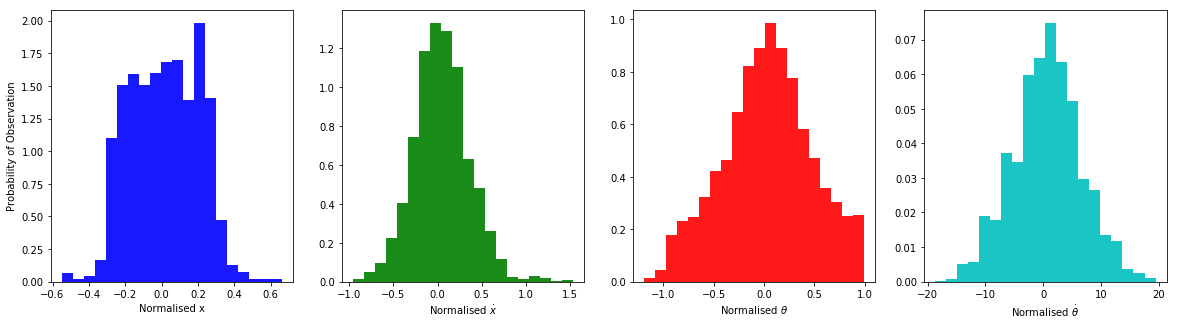

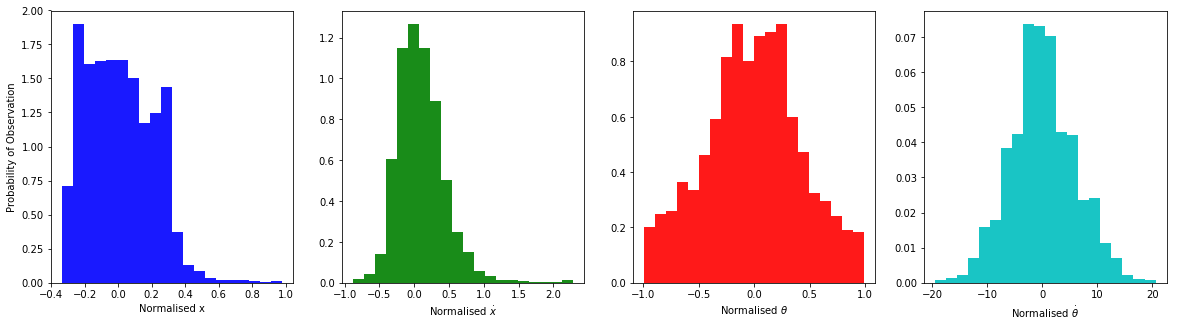

In [31]:
v.plot_observation_histograms(iters=(0, 1, 2), normed=True)

In [ ]:
player_elo = [1083, 838 , 761, 889, 766, 954, 1262, 1254 ,916, 874]